In [1]:
import numpy as np
from scipy.sparse import coo_matrix

import numba
from numba import cuda
import time

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

# timer class is used to measure the time performance of our algorithm
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

def res_red(res):
    n = int(np.sqrt(len(res)))
    res = res.reshape(n,n)
    res = np.delete(res,0,axis=1)
    res = np.delete(res,n-2,axis=1)
    res = np.delete(res,0,axis=0)
    res = np.delete(res,n-2,axis=0)
    return res.flatten()

def u_gen(n):
    u = np.random.RandomState(0).rand(n,n).astype("float64")
    u = np.insert(u,0,0,axis=1)
    u = np.insert(u,len(u[0]),0,axis=1)
    u = np.insert(u,0,0,axis=0)
    u = np.insert(u,len(u),0,axis=0)
    return u.flatten()


In [2]:
@cuda.jit
def mat_A_cuda_shared(u, res, omega = 0):
    n = 198
    local_u = cuda.shared.array((34, 34), numba.float64)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)

    if px >= n or py >= n:
        return

    # the inner 32*32 matrix which associated with each u_{i,j}
    local_u[tx+1, ty+1] = u[n*px + py]

    # transfer the u to a 34*34 shared memory local_u

    if px == 0:
        local_u[tx, ty+1] = 0
    else:
        local_u[tx, ty+1] = u[n*(px-1) + py]

    if px == n-1:
        local_u[tx+2, ty+1] = 0
    else:
        local_u[tx+2, ty+1] = u[n*(px+1) + py]

    if py == 0:
        local_u[tx+1, ty] = 0
    else:
        local_u[tx+1, ty] = u[n*px + py-1]

    if py == n-1:
        local_u[tx+1, ty+2] = 0
    else:
        local_u[tx+1, ty+2] = u[n*px + py+1]

    cuda.syncthreads()    
    # #boundary case
    # if px == 0 or px == n-1 or py == 0 or py == n-1:
    #     res[n*px + py] = local_u[tx+1, ty+1]
    # #interior case
    # else:
    res[n*px + py]=(4*local_u[tx+1,ty+1]-local_u[tx, ty+1]-local_u[tx+2, ty+1]-local_u[tx+1, ty]-local_u[tx+1, ty+2])*(n+1)**2 + omega**2 * u[n*px + py]


In [3]:
# we set the number of points over the grid is 200 along each axis
n = 198
# for the purpose of demonstration u is an array filled with random value with random seed 0
u = np.random.RandomState(0).rand(n*n).astype("float64")
SX = 32
SY = 32
block_rows = (n + 31) // SX
block_cols = (n + 31) // SY

# res = np.zeros(u.shape, dtype=np.float64)
res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
u_cuda = numba.cuda.to_device(u)

omega = 0

mat_A_cuda_shared[(block_rows, block_cols),(SX, SY)](u_cuda, res_cuda, omega)
res_cuda = res_cuda.copy_to_host()

u_cuda = u_cuda.copy_to_host()

In [4]:
A, _ = discretise_poisson(n+2)
u_A = u_gen(n)
res_sample = A @ u_A
res_A = res_red(res_sample)

diff = abs(res_cuda - res_A)
max_diff = np.max(diff)
print("the maximum difference between CUDA and sample method is ", max_diff)

the maximum difference between CUDA and sample method is  5.820766091346741e-11


part ii

In [5]:
rel_error = np.linalg.norm(res_A - res_cuda, np.inf) / np.linalg.norm(res_A, np.inf)
print(f"Relative errorr: {rel_error}.")

Relative errorr: 4.1012501631118684e-16.


In [6]:
def eval_cuda(u):
    # we set the number of points over the grid is 200 along each axis
    n = int(np.sqrt(len(u)))
    # for the purpose of demonstration u is an array filled with random value with random seed 0
    SX = 32
    SY = 32
    block_rows = (n + 31) // SX
    block_cols = (n + 31) // SY

    # res = np.zeros(u.shape, dtype=np.float64)
    res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
    u_cuda = numba.cuda.to_device(u)

    omega = 0

    mat_A_cuda_shared[(block_rows, block_cols),(SX, SY)](u_cuda, res_cuda, omega)
    res_cuda = res_cuda.copy_to_host()

    u_cuda = u_cuda.copy_to_host()
    return res_cuda

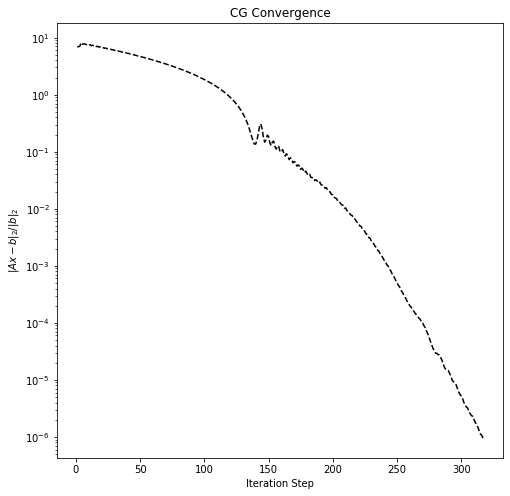

In [13]:
import scipy
from scipy.sparse.linalg import cg

n=198
rand = np.random.RandomState(0)
f = np.ones(n**2)
residuals = []
mapping = scipy.sparse.linalg.LinearOperator(shape=(n**2,n**2), matvec=eval_cuda)
callback = lambda x: residuals.append(np.linalg.norm(mapping(x) - f) / np.linalg.norm(f))

sol, _ = cg(mapping, f, tol=1E-6, callback=callback, maxiter=1000)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(1 + np.arange(len(residuals)), residuals, 'k--')
ax.set_title('CG Convergence')
ax.set_xlabel('Iteration Step')
_ = ax.set_ylabel('$\|Ax-b\|_2 / \|b\|_2$')

In [14]:
sol

array([8.04989812e-05, 1.48372005e-04, 2.08610183e-04, ...,
       2.08610183e-04, 1.48372005e-04, 8.04989812e-05])

In [16]:
sol.shape

(39204,)